In [1]:
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img
from heeps.pupil.create_pupil import create_pupil
from copy import deepcopy
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# Input parameters

In [2]:
pupil_img_size = 39.9988
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
spi_width = 0.5
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
r_obstr = diam_allglass_int/diam_allglass_ext
ravc_t = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4  # 0.76
ravc_r = r_obstr/np.sqrt(1 - ravc_t)                           # 0.62 wrt diam_allglass_ext
diam_allglass_RA = ravc_r*diam_allglass_ext  # 22.929 m
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
r_obstr = diam_fullM1_int/diam_fullM1_ext
ravc_t = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4  # 0.79
ravc_r = r_obstr/np.sqrt(1 - ravc_t)                           # 0.59 wrt diam_fullM1_ext
diam_fullM1_RA = ravc_r*diam_fullM1_ext  # 22.265 m
print(diam_allglass_RA, diam_fullM1_RA)

22.928695205442892 22.26468742885102


# Check all-glass vs full-M1

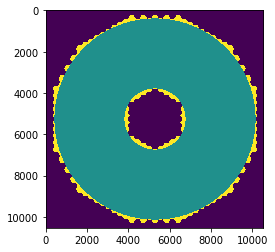

In [3]:
fullM1 = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/mask_M1.fits'))
allglass = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/mask_allglass.fits'))
spiders = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/SpiderShadow.fits'))
imshow(fullM1 - allglass/2)
nimg = fullM1.shape[0]
npupil = 1385

# Create dodecagon (ext) and hexagon (int)

In [4]:
def mask_angle(x, y, r, theta, rot):
    P = (r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta)))
    a = np.tan(np.deg2rad(theta - rot))
    b = P[1] - a*P[0]
    mask = (y > a*x + b) + (y > -a*x + b) + (y < a*x - b) + (y < -a*x - b)
    return mask
def dodecagon(r_ext, nimg):
    x, y = cart_coord(nimg)
    M1 = mask_angle(x, y, r_ext, 0 , 90)
    M2 = mask_angle(x, y, r_ext, 30, 90)
    M3 = mask_angle(x, y, r_ext, 60, 90)
    M4 = mask_angle(x, y, r_ext, 90, 90)
    return M1 + M2 + M3 + M4
def hexagon(r_int, nimg):
    x, y = cart_coord(nimg)
    M5 = mask_angle(x, y, r_int, 30, 60)
    M6 = mask_angle(x, y, r_int, 30, 120)
    return ~(M5 + M6)

In [5]:
# a bit of geometry to find the dodecagon and hexagon edges ...
seg_width = 1.45
alpha = np.arcsin(seg_width/diam_allglass_ext)
ds = seg_width*np.sin(np.pi/3)
dc = seg_width*np.cos(np.pi/3)
beta = np.arcsin(dc/diam_allglass_int)
h = np.cos(beta)*diam_allglass_int
diam_dodecagon = np.cos(alpha)*diam_allglass_ext    # 36.877
diam_hexagon = h - ds + seg_width/np.cos(np.pi/6)   # 11.608
print(diam_dodecagon, diam_hexagon)

36.876503698154465 11.608116201010013


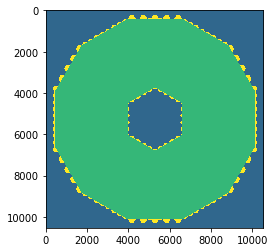

In [6]:
r_ext = diam_dodecagon/pupil_img_size
r_int = diam_hexagon/pupil_img_size
mask = dodecagon(r_ext, nimg) + hexagon(r_int, nimg)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)

# Create Lyot stop

In [7]:
def create_ls(d_ext, d_int, ls_dRext, ls_dRint, ls_dRspi, circ_ext=True, \
    circ_int=True):
    # create spider stop
    conf = dict(
        npupil=nimg,
        pupil_img_size=pupil_img_size, 
        diam_ext=80,        # no circular aperture
        diam_int=0,         # no circular obscuration
        seg_width=0,        # no segments
        spi_width=spi_width + ls_dRspi*diam_nominal_ext,
    )
    mask_spi = create_pupil(**conf)
    # create outer and inner stops
    r_ext = (d_ext - ls_dRext*diam_nominal_ext) / pupil_img_size
    r_int = (d_int + ls_dRint*diam_nominal_ext) / pupil_img_size
    r, t = polar_coord(nimg)
    mask_ext = (r < r_ext) if circ_ext == True else ~dodecagon(r_ext, nimg)
    mask_int = (r > r_int) if circ_int == True else ~hexagon(r_int, nimg)
    # lyot stop
    return mask_spi * mask_ext * mask_int

# Lyot stop RAVC
## LM band

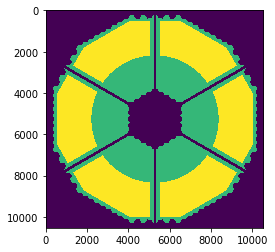

In [8]:
mask = create_ls(diam_allglass_ext, diam_fullM1_RA, 0.0282, 0.0282, 0.037)
fits.writeto('ls_LM_RAVC_circ.fits', resize_img(mask, npupil), overwrite=True)

mask = create_ls(diam_allglass_ext, diam_allglass_RA, 0.0282, 0.0282, 0.037)
fits.writeto('ls_LM_RAVC_allglass.fits', resize_img(mask, npupil), overwrite=True)

mask = create_ls(diam_dodecagon, diam_fullM1_RA, 0.0282, 0.0282, 0.037, circ_ext=False)
fits.writeto('ls_LM_RAVC_dodecagon.fits', resize_img(mask, npupil), overwrite=True)
imshow(fullM1*spiders + mask/2)

## N band

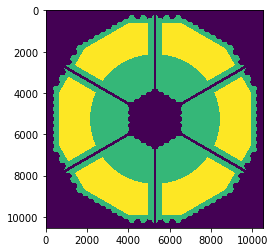

In [9]:
mask = create_ls(diam_allglass_ext, diam_allglass_RA, 0.04, 0.04, 0.05)
fits.writeto('ls_N_RAVC_allglass.fits', resize_img(mask, npupil), overwrite=True)

mask = create_ls(diam_allglass_ext, diam_fullM1_RA, 0.04, 0.04, 0.05)
fits.writeto('ls_N_RAVC_circ.fits', resize_img(mask, npupil), overwrite=True)

mask = create_ls(diam_dodecagon, diam_fullM1_RA, 0.04, 0.04, 0.05, circ_ext=False)
fits.writeto('ls_N_RAVC_dodecagon.fits', resize_img(mask, npupil), overwrite=True)
imshow(fullM1*spiders + mask/2)

# Lyot stop CVC
## LM band

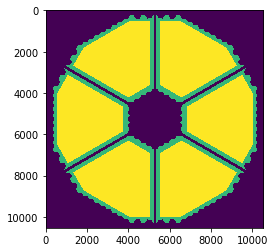

In [10]:
mask = create_ls(diam_allglass_ext, diam_allglass_int, 0.0282, 0.05, 0.037)
fits.writeto('ls_LM_CVC_circ.fits', resize_img(mask, npupil), overwrite=True)

mask = create_ls(diam_dodecagon, diam_hexagon, 0.0282, 0.05, 0.037, \
    circ_ext=False, circ_int=False)
fits.writeto('ls_LM_CVC_dodecagon.fits', resize_img(mask, npupil), overwrite=True)
imshow(fullM1*spiders + mask/2)

## N band

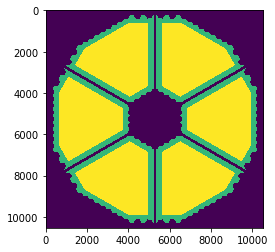

In [11]:
mask = create_ls(diam_allglass_ext, diam_allglass_int, 0.04, 0.05, 0.05)
fits.writeto('ls_N_CVC_circ.fits', resize_img(mask, npupil), overwrite=True)

mask = create_ls(diam_dodecagon, diam_hexagon, 0.04, 0.05, 0.05, \
    circ_ext=False, circ_int=False)
fits.writeto('ls_N_CVC_dodecagon.fits', resize_img(mask, npupil), overwrite=True)
imshow(fullM1*spiders + mask/2)

# Lyot stop CLC
## LM band

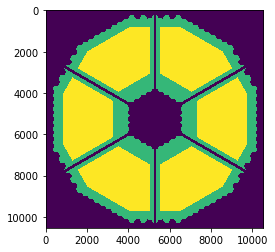

In [12]:
# values from Muskan wrt diam_nominal_ext
ls_dRext = diam_allglass_ext/diam_nominal_ext - 0.78
ls_dRint = 0.45 - diam_allglass_int/diam_nominal_ext
mask = create_ls(diam_allglass_ext, diam_allglass_int, ls_dRext, ls_dRint, 0.037)
fits.writeto('ls_LM_CLC_circ.fits', resize_img(mask, npupil), overwrite=True)

ls_dRext = diam_allglass_ext/diam_nominal_ext - 0.88
ls_dRint = 0.45 - diam_allglass_int/diam_nominal_ext
mask = create_ls(diam_dodecagon, diam_hexagon, ls_dRext, ls_dRint, 0.037, \
    circ_ext=False, circ_int=False)
fits.writeto('ls_LM_CLC_dodecagon.fits', resize_img(mask, npupil), overwrite=True)
imshow(fullM1*spiders + mask/2)

## N band ...